<a href="https://colab.research.google.com/github/NahinAlam001/499B/blob/classification/PH2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import shutil
import random
import gdown
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from skimage.io import imread
from pathlib import Path
from PIL import Image
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomAffine
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [ ]:
gdown.download('https://drive.google.com/uc?id=12n80fPYakuYklZ0jv9834cs5iYJJ6pJM', 'image.zip', quiet=False)
with zipfile.ZipFile('image.zip', 'r') as zip_ref:
  zip_ref.extractall()

shutil.move('ph2/ph2_dataset_master', 'data')

Downloading...
From (original): https://drive.google.com/uc?id=12n80fPYakuYklZ0jv9834cs5iYJJ6pJM
From (redirected): https://drive.google.com/uc?id=12n80fPYakuYklZ0jv9834cs5iYJJ6pJM&confirm=t&uuid=a66420e0-bd6c-460f-b32b-24918490d276
To: /content/image.zip
100%|██████████| 150M/150M [00:04<00:00, 30.5MB/s]


In [ ]:
data = pd.read_excel('data/PH2_simple_dataset.xlsx')
data.describe()

,image_name,diagnosis
count,200,200
unique,200,3
top,IMD003,Common Nevus
freq,1,80


In [ ]:
data_path = 'data/images'
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')

os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

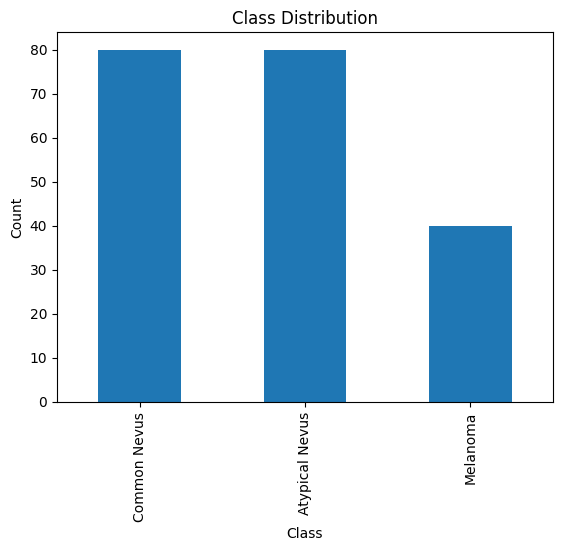

In [ ]:
class_distribution = data['diagnosis'].value_counts()
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['diagnosis'], random_state=42)
len(train_data), len(test_data)

(160, 40)

In [ ]:
def move_images(data, destination):
    skipped_count = 0
    for _, row in data.iterrows():
        image_name = row['image_name']
        if not image_name.endswith('.jpg'):
            image_name += '.jpg'
        diagnosis = row['diagnosis']
        source_path = os.path.join(data_path, image_name)
        destination_class_path = os.path.join(destination, diagnosis)
        os.makedirs(destination_class_path, exist_ok=True)
        destination_image_path = os.path.join(destination_class_path, image_name)
        try:
            shutil.move(source_path, destination_image_path)
        except FileNotFoundError:
            print(f"File '{image_name}' not found in directory. Skipping...")
            skipped_count += 1
            continue

    return skipped_count

train_skipped_count = move_images(train_data, train_path)
test_skipped_count = move_images(test_data, test_path)

print(f"Total skipped images in train set: {train_skipped_count}")
print(f"Total skipped images in test set: {test_skipped_count}")

Total skipped images in train set: 0
Total skipped images in test set: 0


In [ ]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    if len(filenames) != 0:
      print(f'There are {len(filenames)} images in {dirpath}')

walk_through_dir(data_path)

There are 64 images in data/images/train/Atypical Nevus
There are 64 images in data/images/train/Common Nevus
There are 64 images in data/images/train/Melanoma
There are 16 images in data/images/test/Atypical Nevus
There are 16 images in data/images/test/Common Nevus
There are 8 images in data/images/test/Melanoma


In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: torch.clamp(x, 0, 1))
])

In [ ]:
train_dir = 'data/images/train'

classes_counts = {
    'Atypical Nevus': 64,
    'Common Nevus': 64,
    'Melanoma': 32
}

max_count = max(classes_counts.values())

for class_name, count in classes_counts.items():
  if count < max_count:

    num_new_images = max_count - count


    image_files = os.listdir(os.path.join(train_dir, class_name))

    i = 0
    for image_file in image_files:
      if i >= num_new_images:
          break


      img_path = os.path.join(train_dir, class_name, image_file)
      img = Image.open(img_path)


      img_transformed = transform(img)
      img_transformed = transforms.ToPILImage()(img_transformed).convert("RGB")
      img_transformed.save(os.path.join(train_dir, class_name, f'aug_{i}.jpg'))

      i += 1

In [ ]:
for class_name in classes_counts.keys():
    print(f"{class_name}: {len(os.listdir(os.path.join(train_dir, class_name)))}")

Atypical Nevus: 64
Common Nevus: 64
Melanoma: 64


In [ ]:
train_data = ImageFolder(root=train_path,
                      transform=transform,
                      target_transform=None)

test_data = ImageFolder(root=test_path,
                      transform=transform)

In [ ]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = os.cpu_count())

test_dataloader = DataLoader(dataset = test_data,
                              batch_size = BATCH_SIZE,
                              shuffle = False,
                              num_workers = os.cpu_count())

In [ ]:
data_path = Path('data')
image_path = data_path/'images'

image_path_list = list(image_path.glob('*/*/*.jpg'))
len(image_path_list)

232

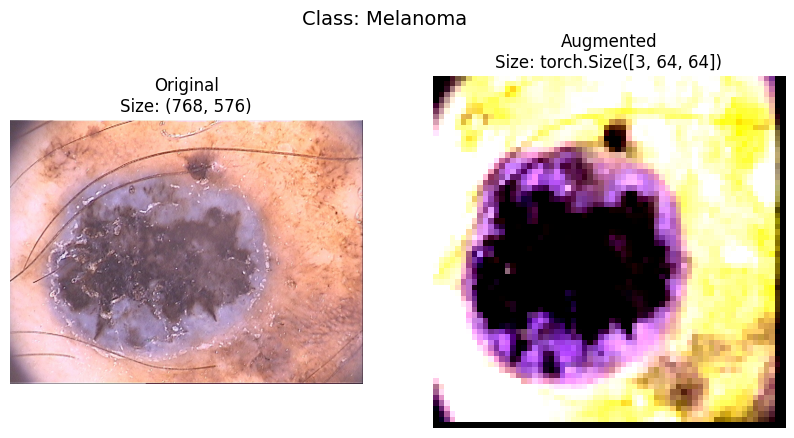

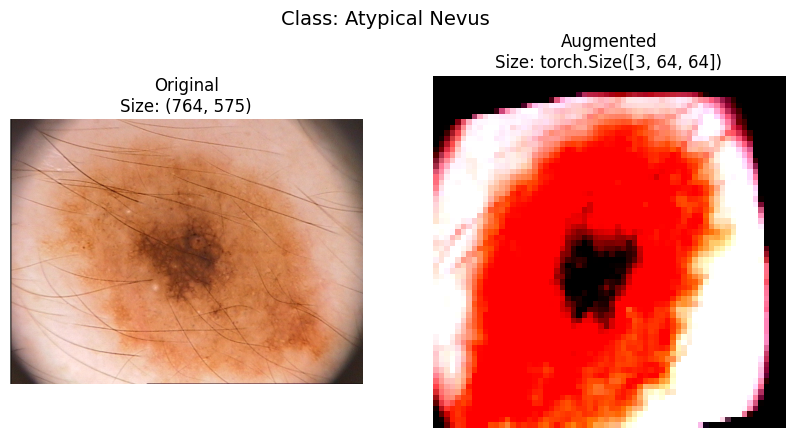

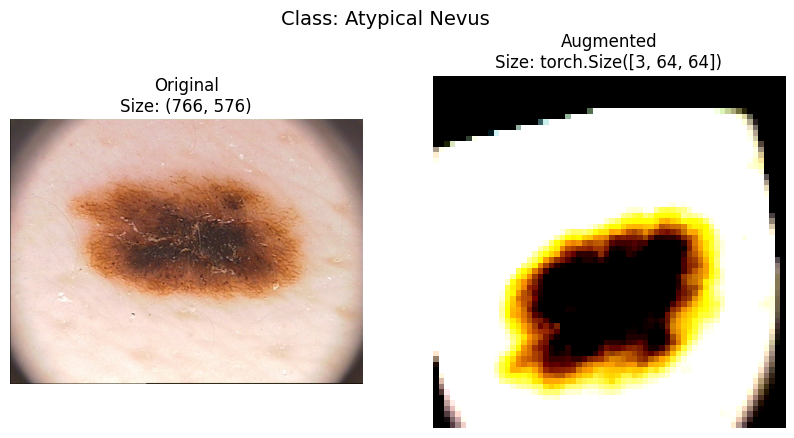

In [ ]:
def visualizing(image_paths: list, transform, n=3, seed=None):
    if seed:
        random.seed(seed)

    random_images = random.sample(image_paths, k=n)

    for image_path in random_images:
        with Image.open(image_path) as img:
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            fig.suptitle(f'Class: {Path(image_path).parent.stem}', fontsize=14)


            axs[0].imshow(img)
            axs[0].set_title(f'Original\nSize: {img.size}')
            axs[0].axis('off')


            transformed_img = transform(img)


            axs[1].imshow(transformed_img.permute(1, 2, 0))
            axs[1].set_title(f'Augmented\nSize: {transformed_img.shape}')
            axs[1].axis('off')

            plt.show()


visualizing(image_path_list, transform, 3, seed=42)

##CNN

In [ ]:
class CNNModel(nn.Module):
  def __init__(self, num_classes):
    super(CNNModel, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding='same')
    self.bn1 = nn.BatchNorm2d(16)
    self.pool1 = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding='same')
    self.bn2 = nn.BatchNorm2d(32)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
    self.bn3 = nn.BatchNorm2d(64)
    self.pool3 = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64 * 8 * 8, 512)
    self.dropout1 = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(512, num_classes)

  def forward(self, x):
    x = self.pool1(F.relu(self.bn1(self.conv1(x))))
    x = self.pool2(F.relu(self.bn2(self.conv2(x))))
    x = self.pool3(F.relu(self.bn3(self.conv3(x))))
    x = x.view(-1, 64 * 8 * 8)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel(num_classes=len(train_data.classes)).to(device)

optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    model.train()
    for batch, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (output.argmax(1) == target).sum().item()

    print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss/len(train_data):.4f} | Train Acc: {train_acc/len(train_data):.4f}')

# Testing loop
test_acc = 0
model.eval()
with torch.no_grad():
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_acc += (output.argmax(1) == target).sum().item()

print(f'Test Accuracy: {test_acc/len(test_data):.4f}')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1/50 | Train Loss: 0.0560 | Train Acc: 0.4479
Epoch: 2/50 | Train Loss: 0.0404 | Train Acc: 0.5312
Epoch: 3/50 | Train Loss: 0.0328 | Train Acc: 0.5573
Epoch: 4/50 | Train Loss: 0.0297 | Train Acc: 0.5417
Epoch: 5/50 | Train Loss: 0.0277 | Train Acc: 0.5885
Epoch: 6/50 | Train Loss: 0.0263 | Train Acc: 0.6198
Epoch: 7/50 | Train Loss: 0.0268 | Train Acc: 0.5729
Epoch: 8/50 | Train Loss: 0.0248 | Train Acc: 0.6406
Epoch: 9/50 | Train Loss: 0.0217 | Train Acc: 0.6667
Epoch: 10/50 | Train Loss: 0.0237 | Train Acc: 0.6823
Epoch: 11/50 | Train Loss: 0.0210 | Train Acc: 0.6875
Epoch: 12/50 | Train Loss: 0.0230 | Train Acc: 0.6667
Epoch: 13/50 | Train Loss: 0.0219 | Train Acc: 0.6615
Epoch: 14/50 | Train Loss: 0.0214 | Train Acc: 0.6771
Epoch: 15/50 | Train Loss: 0.0211 | Train Acc: 0.6771
Epoch: 16/50 | Train Loss: 0.0239 | Train Acc: 0.6562
Epoch: 17/50 | Train Loss: 0.0208 | Train Acc: 0.7031
Epoch: 18/50 | Train Loss: 0.0210 | Train Acc: 0.6510
Epoch: 19/50 | Train Loss: 0.0203 | T